In [2]:
import pandas as pd
import numpy as np
from itertools import permutations
import copy
import pickle

from sklearn.metrics import mean_squared_error
import lightgbm as lgb

import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2
from main.utils.preprocessing import preprocess_census
from main.estimators.evaluation import cv_early_stopping
from main.fairness.metrics import get_all_predictions, calculate_metrics
from main.utils.dataloader import load_sunbelt_data

In [4]:
sunbelt_states = ['AL', 'AZ', 'FL', 'GA', 'LA', 
                  'MS', 'NM', 'SC', 'TX', 'CA']

data_all = load_sunbelt_data(states=sunbelt_states)

In [5]:
cat_features = ['OCCP', 'POBP', 'SCHL', 'RELP']

ret_dict =  preprocess_census(data=data_all,
                              target_feature='PINCP',
                              sensitive_features=['SEX', 'RAC1P_black'],
                              categorical_features=cat_features,
                              continuous_features=['WKHP', 'AGEP'])

In [6]:
params = {
    "objective": "regression",
    "metric": "mse",
    "min_data_in_leaf": 50,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "verbose": -1
}

cv_results = cv_early_stopping(params=params, 
                               nfolds=5, 
                               max_rounds=1000, 
                               early_stopping_rounds=20, 
                               X_train=ret_dict['X_train'], 
                               y_train=ret_dict['y_train'], 
                               categorical_feats=cat_features)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[569]	validation's l2: 0.552022
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[415]	validation's l2: 0.547966
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[544]	validation's l2: 0.546421
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[574]	validation's l2: 0.545016
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[295]	validation's l2: 0.54502


In [7]:
best_res = np.argmin(cv_results['metric'])
best_iter = cv_results['iterations'][best_res]

print((f"Best MSE: {np.min(cv_results['metric'])} \nBest Iter: {best_iter}"))

Best MSE: 0.5450164220371625 
Best Iter: 574


In [8]:
# Retrain whole model
data_train_all = lgb.Dataset(data=ret_dict['X_train'], 
                             label=ret_dict['y_train'], 
                             categorical_feature=cat_features)

best_estimator = lgb.train(params=params,
                           train_set=data_train_all, 
                           num_boost_round=best_iter)

In [9]:
prediction_baseline = best_estimator.predict(ret_dict['X_test'])

In [10]:
mean_squared_error(ret_dict['y_test'], prediction_baseline)

0.5467691821346675

In [11]:
output_check = get_all_predictions(best_estimator, 
                                   ['SEX_2', 'RAC1P_black'], 
                                   ret_dict)

saving mods
saving mods
saving mods
saving mods


In [12]:
output_check['baseline'] = {}
output_check['baseline']['level_0'] = {}
output_check['baseline']['level_0']['prediction'] = prediction_baseline
output_check['baseline']['level_0']['sensitive'] = {}
output_check['baseline']['level_0']['sensitive']['SEX'] = ret_dict['X_test']['SEX_2']
output_check['baseline']['level_0']['sensitive']['RACE'] = ret_dict['X_test']['RAC1P_black']

In [13]:
ret_metrics = calculate_metrics(output_check, 
                  ret_dict['y_test'])

In [19]:
# with open('data/prepared/all_results_application.pkl', 'wb') as con_:
#     pickle.dump(output_check, con_)

In [14]:
# with open('data/results/application_visualisation.pkl', 'wb') as con_:
#     pickle.dump(ret_metrics, con_)

In [15]:
# with open('data/results/application_data_dict.pkl', 'wb') as con_:
#     pickle.dump(ret_dict, con_)


In [16]:
# best_estimator.save_model('data/models/best_iteration_model.txt',
#                                    num_iteration = best_iter)

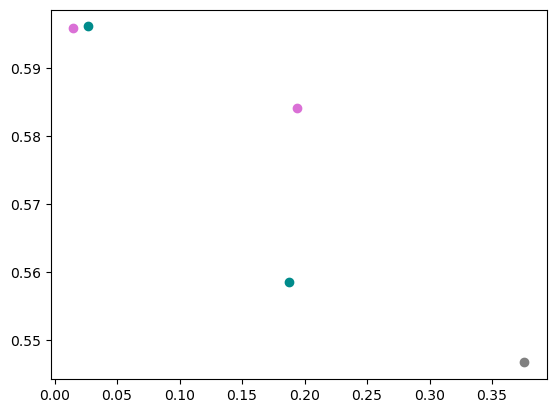

In [17]:
col_dict = {'A': u'orchid', 'B': u'darkcyan', 'C': u'grey', 'D': u'dodgerblue', 'E': u'turquoise', 'F': u'darkviolet'}


all_cols = dict(zip(range(len(col_dict.values())), col_dict.values()))

col_counter = 0

for key_final, val_final in ret_metrics.items():
    for key_level in val_final.keys():
        plt.scatter(val_final[key_level]['unfairness'], 
                    val_final[key_level]['mse'], 
                    c=all_cols[col_counter])
    col_counter += 1